In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ipywidgets import widgets, interactive
import plotly.figure_factory as ff
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from bs4 import BeautifulSoup
import time
from selenium.common.exceptions import StaleElementReferenceException
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

# Sentiment Analysis of Spotify's Top 50 of 2010

Now comes another interesting part of this project - incorporating lyrical sentiment analysis into how we view a song. We all have experience where the music can compound the lyrics and give it a powerful effect. For the time being, we will start with the most popular songs of the past decade - is it possible that this is something that makes these songs so popular? 

So we will start by taking the file that was made from running the other notebook (SpotifyAudioFeatures).

In [2]:
%run -i 'client_id_script.py'

In [3]:
tens_df = pd.read_csv('top2010s.csv')

However, because we are reading a csv, some of the columns that were once lists or numerical values are not strings... thus, we'll have to make some edits to change those back.

In [4]:
tens_df.head()

,Name,Artists,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,One Dance,"['Drake', 'WizKid', 'Kyla']",0.00776,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001880,1,0.3290,-5.609,1,0.0536,103.967,4,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370
1,Lean On (feat. MØ & DJ Snake),"['Major Lazer', 'MØ', 'DJ Snake']",0.00346,https://api.spotify.com/v1/audio-analysis/1qE4...,0.723,176561,0.809,1qE47wUKG2juJwPoLqg4C9,0.001230,7,0.5650,-3.081,0,0.0625,98.007,4,https://api.spotify.com/v1/tracks/1qE47wUKG2ju...,audio_features,spotify:track:1qE47wUKG2juJwPoLqg4C9,0.274
2,Sunflower - Spider-Man: Into the Spider-Verse,"['Post Malone', 'Swae Lee']",0.53300,https://api.spotify.com/v1/audio-analysis/0RiR...,0.755,157560,0.522,0RiRZpuVRbi7oqRdSMwhQY,0.000000,2,0.0685,-4.368,1,0.0575,89.960,4,https://api.spotify.com/v1/tracks/0RiRZpuVRbi7...,audio_features,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,0.925
3,Somebody That I Used To Know,"['Gotye', 'Kimbra']",0.54800,https://api.spotify.com/v1/audio-analysis/1qDr...,0.865,244885,0.521,1qDrWA6lyx8cLECdZE7TV7,0.000115,0,0.0989,-6.932,1,0.0371,129.059,4,https://api.spotify.com/v1/tracks/1qDrWA6lyx8c...,audio_features,spotify:track:1qDrWA6lyx8cLECdZE7TV7,0.748
4,Rolling in the Deep,['Adele'],0.13100,https://api.spotify.com/v1/audio-analysis/1Ckv...,0.729,228293,0.756,1CkvWZme3pRgbzaxZnTl5X,0.000000,8,0.0527,-5.119,1,0.0294,104.945,4,https://api.spotify.com/v1/tracks/1CkvWZme3pRg...,audio_features,spotify:track:1CkvWZme3pRgbzaxZnTl5X,0.522


In [5]:
rsults = []
for i in range(len(tens_df)):
    result = [x.strip() for x in tens_df.iloc[i]["Artists"].replace("[", "").replace("]", "").replace("'", "").split(",")]
    rsults.append(result)
tens_df["Artists"] = rsults

In [6]:
to_change = ["acousticness", 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
            'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 
            'time_signature', 'valence']

for column in to_change:
    tens_df[column] = tens_df[column].astype(float)

For our sentiment analysis, we will be using a package called VADER (Valence Aware Dictionary and sEntiment Reasoner). It is specifically geared toward uncovering sentiment in social media. This may not be the perfect sentiment analysis package, but this could be used to compare to another sentiment analysis tool in the future.

In [7]:
analyser = SentimentIntensityAnalyzer()

In [8]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

For VADER, we can look at sentences (or even paragraphs) and see what proportion of the sentence is considered "positive", "negative", or "neutral" in sentiment. From combining these three features together, we can get the compound score of how positive/negative the lyrics are. We will test this out with lyrics from the song 'Let it Go':

In [9]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore \n Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Can't hold it back anymore 
 Let it go, let it go 
 Turn away and slam the door {'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.3818}


When we look at the entire phrase, we see that it's slightly negative, mostly neutral, and not positive at all. However, we can also break the sentence in half to see the difference between the two lines:

In [10]:
sentiment_analyzer_scores("Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Turn away and slam the door {'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'compound': -0.3818}


In [11]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore")

Let it go, let it go 
 Can't hold it back anymore {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


That gives us a basic look into how we will use the package.

## Web Scraping

Unfortunately, the lyrics won't get themselves. I could have just manually google-searched every song for its lyrics, but that would be a lot of work, and it's cool to be able to find a way to automate the simple things in life with a script. We will take a look at my approach and how I came to finally getting all the lyrics.

### Testing... Google Search

When looking up lyrics, the first thought would probably be: "Let me google that", and the lyrics of the song will appear on the search page. I went ahead and tried that. To do this, you will need a few things:

Selenium (Python package)  
BeautifulSoup (Python package)  
Chrome Driver

When you have the first two downloaded and you have the path to where the chrome driver file is, you can run the script below (be sure to replace the file path). I used this in a previous project, so I can access my chrome driver from that folder.

In [12]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
search_string = "let+it+go+lyrics"

browser.get("https://www.google.com/search?q=" + search_string)
    #clickme = browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']")
    #clickme = browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
    #clickme.click()
    #with wait_for_page_load(browser):
browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']").click()
time.sleep(5)
    #WebDriverWait(browser, 20).until(lambda browser: browser.execute_script("return document.readyState;") == "complete")
    #browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
matched_elements = browser.page_source

browser.close()

Running the above will get us the page, but we will need to make it parsable. Which is where BeautifulSoup comes in handy. 

After running the below cell, you may realize that it's difficult to try to find where the lyrics are on the page. It takes some looking into the structure of the html, but you will be able to find it, and when you do, you'll be able to get the lyrics.

In [13]:
nsoup = BeautifulSoup(matched_elements, 'html.parser')
#nsoup.findAll('span', jsname = "YS01Ge")

In [14]:
#nsoup.findAll('div', role = "button")

In [216]:
nsoup.findAll('span', jsname = "YS01Ge")[0:5]

[<span jsname="YS01Ge">The snow glows white on the mountain tonight</span>,
 <span jsname="YS01Ge">Not a footprint to be seen</span>,
 <span jsname="YS01Ge">A kingdom of isolation</span>,
 <span jsname="YS01Ge">And it looks like I'm the queen</span>,
 <span jsname="YS01Ge">The wind is howling like this swirling storm inside</span>]

We have the lyrics, so it works, right? Not so fast... unfortunately, if you look carefully at the lyrics, you'll notice a section that goes:

In [214]:
nsoup.findAll('span', jsname = "YS01Ge")[23:28]

[<span jsname="YS01Ge">Let it go</span>,
 <span jsname="YS01Ge">Let it go</span>,
 <span jsname="YS01Ge">It's funny how some distance makes</span>,
 <span jsname="YS01Ge">It's funny how some distance makes everything seem small</span>,
 <span jsname="YS01Ge">And the fears that once controlled me can't get to me at all</span>]

If you look at the Google Search page, you'll notice that there's a button that the user has to click on to get all the lyrics. Before you click, you get the first line. But after you click on it, you get the second line. However, the page source shows both lines. This would take an extra step to try to figure out, because you'd have to be able to figure out a pattern for where this phenomenon occurs for each song.

We can test it with another song, "We are Young" by FUN:

In [16]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
searchi_string = "we+are+young+featuring+janelle+monae+lyrics"

for i in range(1): 
    browser.get("https://www.google.com/search?q=" + searchi_string)
    elements = browser.page_source

browser.close()

In [222]:
soup = BeautifulSoup(elements, 'html.parser')
soup.findAll('span', jsname = "YS01Ge")[0:5]

[<span jsname="YS01Ge">Give me a second I</span>,
 <span jsname="YS01Ge">I need to get my story straight</span>,
 <span jsname="YS01Ge">My friends are in the bathroom getting higher than the Empire State</span>,
 <span jsname="YS01Ge">My lover she's waiting for me just across the bar</span>,
 <span jsname="YS01Ge">My seat's been taken by some sunglasses asking about a scar, and</span>]

In [218]:
soup.findAll('span', jsname = "YS01Ge")[18:23]

[<span jsname="YS01Ge">Now I know that I'm not</span>,
 <span jsname="YS01Ge">All that you got, I guess that I, I just thought</span>,
 <span jsname="YS01Ge">Maybe we could find new ways</span>,
 <span jsname="YS01Ge">Give me a second I</span>,
 <span jsname="YS01Ge">I need to get my story straight</span>]

In [221]:
soup.findAll('span', jsname = "YS01Ge")[39:44]

[<span jsname="YS01Ge">Now I know that I'm not</span>,
 <span jsname="YS01Ge">All that you got, I guess that I, I just thought</span>,
 <span jsname="YS01Ge">Maybe we could find new ways to fall apart</span>,
 <span jsname="YS01Ge">But our friends are back</span>,
 <span jsname="YS01Ge">So let's raise a tab</span>]

This one is even tougher, because instead of one line, it looks after the part where it cuts off, it restarts the whole set of lyrics again.

### Moving on to AZ Lyrics

So what next? We will try AZ lyrics, a website that contains accessible lyrics of popular songs. We will try this with another song in our playlist:

In [18]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "shakira"
song = "wakawakathistimeforafrica"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    el = browser.page_source

browser.close()

In [19]:
so = BeautifulSoup(el, 'html.parser')

Running the commented-out line will give us every text item in the page source. From here, we can parse through it to get our desired lyrics. 

Luckily, the page structure for all of the lyrics look quite similar. We will try this pattern below to see if we can get all of the lyrics

In [21]:
beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
en = so.findAll(text = True).index(' MxM banner ')

In [22]:
#so.findAll(text = True)[beg + 1:en].apply(strip("/n"))
lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
sentiment_analyzer_scores(" ".join(lyr))

Oooeeeeeeeeeeeeeeeehh  You're a good soldier Choosing your battles Pick yourself up And dust yourself off Get back in the saddle  You're on the front line Everyone's watching You know it's serious We're getting closer This isn't over  The pressure's on You feel it But you got it all Believe it  When you fall get up, oh oh If you fall get up, eh eh Tsamina mina zangalewa 'Cause this is Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa  Listen to your God This is our motto Your time to shine Don't wait in line Y vamos por todo  People are raising Their expectations Go on and feed them This is your moment No hesitation  Today's your day I feel it You paved the way Believe it  If you get down get up, oh oh When you get down get up, eh eh Tsamina mina zangalewa This time for Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa Anawa a a Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa   [Zolani:] Ame la me

It looks like it gets the job done, giving us the lyrics as well as the score. An interesting thing with lyrics is that often there is no punctuation, which is a supposed to be a helpful indicator of sentiment for the social media-focused VADER package. It will likely affect our analysis to some degree. But we can consider some ways to mitigate this, such as analyzing verses at a time or something else.

We will test this out again on another song in our playlist, so the below cells are similar to above.

In [23]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "xxxtentacion"
song = "sad"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    eles = browser.page_source

browser.close()

In [24]:
s = BeautifulSoup(eles, 'html.parser')
#s.findAll("div")[14]

In [25]:
s.find('div', text = "Yeah")

In [26]:
begi = s.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
endo = s.findAll(text = True).index(' MxM banner ')
lyrim = [x.strip("\n") for x in s.findAll(text = True)[begi + 1:endo]]
analyser.polarity_scores(" ".join(lyrim))

{'neg': 0.263, 'neu': 0.62, 'pos': 0.117, 'compound': -0.9957}

We have a lot of scripting, but it does make up for things in the long run, allowing us to save time in the process of getting what we want.

In [27]:
# prepares artist name so that it can be used to get the link of the song on AZ lyrics
def azartistprep(artist):
    if "&" in artist:
        art, tist = artist.split("&")
        return art.lower().replace(" ", "").replace(".", "")
    if "The" in artist:
        art, tist = artist.split("The")
        return tist.lower().replace(" ", "").replace(".", "")
    return artist.lower().replace(" ", "").replace(".", "")

# prepares song name so that it can be used to get the link of the song on AZ lyrics
def azlyricprep(song):
    if " - " in song:
        end = ""
        a, b = song.split("-", 1)
        if a == "Cheerleader":
            return "cheerleaderfelixjaehnremix"
        if "Remix" in b:
            c, d = b.split("Remix")
            end += c.lower().replace(" ", "") + "remix"
        a = a.lower().replace(" ", "")
        a += end
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "[" in song:
        a, b = song.split("[", 1)
        a = a.lower().replace("(", "").replace(")", "").replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "(feat." in song:
        a, b = song.split("(feat.", 1)
        a = a.lower().replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "")
    else:
        return song.lower().replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "").replace(" ", "").replace("ñ", "n")

In [28]:
azlyricprep("Waka Waka (This Time for Africa) [The Official. (feat.)")

'wakawakathistimeforafrica'

The two cells below incorporates all of the work and investigation that we did in relation to lyrics from AZ lyrics, allowing us to obtain the page sources for all the lyrics playlist, plus extract just the lyrics for every song.

In [29]:
sources = []

browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source

for index, song in tens_df.iterrows():
    singer = azartistprep(song["Artists"][0])
    song = azlyricprep(song["Name"])
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    sources.append(browser.page_source)
    time.sleep(10)

browser.close()

In [30]:
lyrics = []
for source in sources:
    so = BeautifulSoup(source, 'html.parser')
    beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
    en = so.findAll(text = True).index(' MxM banner ')
    lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
    lyrics.append(lyr)

## Sentiment Analysis



### Analysis of Word Usage

Before we throw our lyrics into the sentiment analyzer, let's do a little dive into our lyrics. We can look to see what words are found in all the songs, and make up the bulk of the words. In a sense, this can help to crystallize the feeling of the music of the 2010s.

To begin, we will use the natural language processing package NLTK, which can give us access to a list of stopwords. These "stopwords" generally do not give us much info related to sentiment, and can impact our results because of how commonplace they are in the english language. These words include "I", "you", "am", etc.

In [161]:
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

After looking into our words a little bit more, there are other common words that we will add to our stopword set. We will be ignoring these words in our counting.

In [162]:
stops.update({"ya", "i'll", "whoa", "wa",
              'ooh', 'eeh', 'ayy', "woah", "doo",
             "oh", "na", "aha", "we're", 'doh',
             "i'd", "n", "e", "it's", "we've",
             "&", "$", ":", "la", "uh", "i'm", 
             "aah", "bada"})

In [165]:
# a function to help pre-process lyrics
def remover(lyric):
    lyric = lyric.replace("-", " ")
    lyric = lyric.replace("(", "").replace(")", "").replace('\\', "").replace(",", "").replace(".", "").replace("?", "").replace('"', "")
    return lyric.lower()

In [259]:
# a function that pre-processes and counts up non-stop words
def word_count(lyrics, diction = {}, single = False):
    # only used if single == True
    word_set = set()
    lyrics = remover(lyrics)
    for word in lyrics.split():
        if "[" in word:
            continue
        if "]" in word:
            continue
        if word in stops:
            continue
        if word[-3:] == "in'":
            word = word[:-3] + "ing"
        if word not in diction:
            diction[word] = 1
            word_set.add(word)
        else: 
            if single == False:
                diction[word] += 1
            else:
                if word in word_set:
                    continue
                else:
                    diction[word] += 1
                    word_set.add(word)
                    
    return diction

In [260]:
test = lyrics[18]

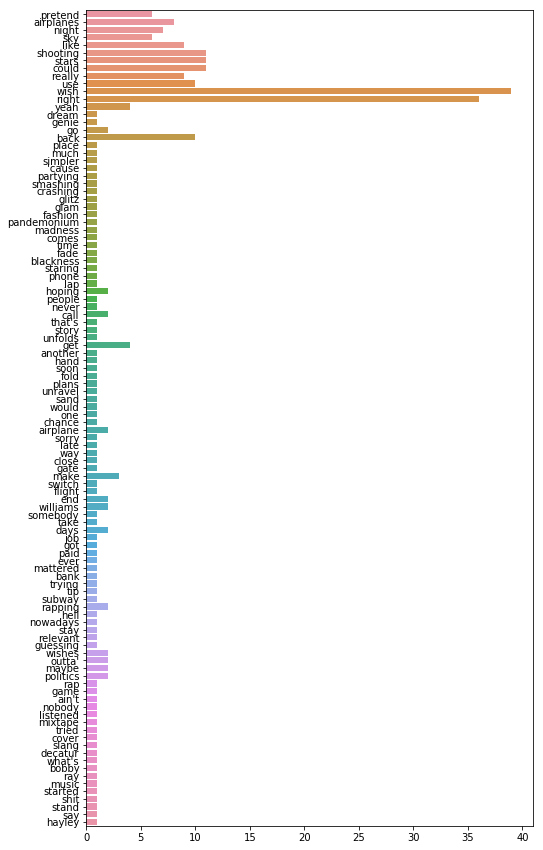

In [261]:
plt.figure(figsize=(8, 15))
sns.barplot(x = list(test_dict.values()), y = list(test_dict.keys()))

In [262]:
diction = {}
for lyric in lyrics:
    diction = word_count(" ".join(lyric), diction)

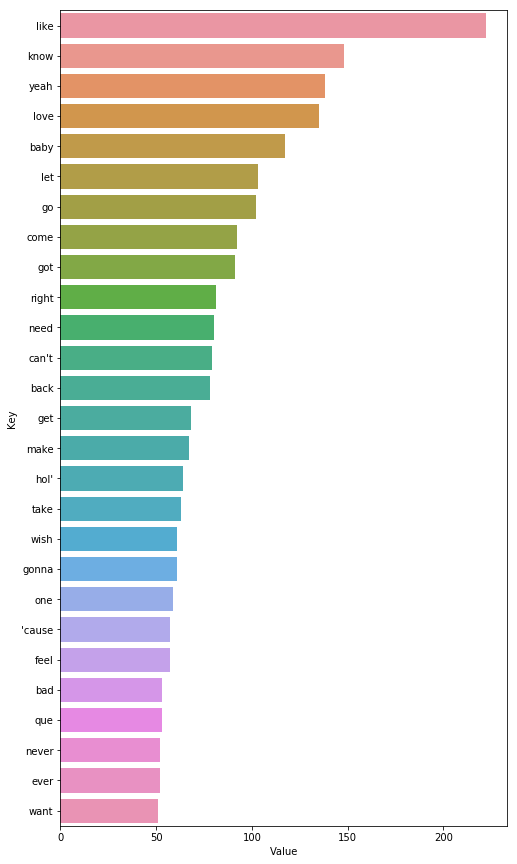

In [264]:
sub = {key: value for key, value in diction.items() if value > 50}

sub_diction = pd.DataFrame()
sub_diction["Key"] = list(sub.keys())
sub_diction["Value"] = list(sub.values())
sub_diction = sub_diction.sort_values("Value", ascending = False)

plt.figure(figsize=(8, 15))
sns.barplot(x = sub_diction["Value"], y = sub_diction["Key"])

Words like "need", "want", "wish" show a sense of yearning that comes from the lyrics of these songs, as well as "love" and "baby". Depending on the usage, the word "like" can also be used in that sense. However, it is also a possible filler word, which can explain how common it is used.

However, something to be careful of when doing word counts to generalize over a playlist is to see how many songs do these words appear in. Let's take a look at this by running the cells below. It is very similar to what we do above, but instead we are only counting if the word appears in each song, not how many times it appears.

In [265]:
single_diction = {}
for lyric in lyrics:
    single_diction = word_count(" ".join(lyric), single_diction, single = True)

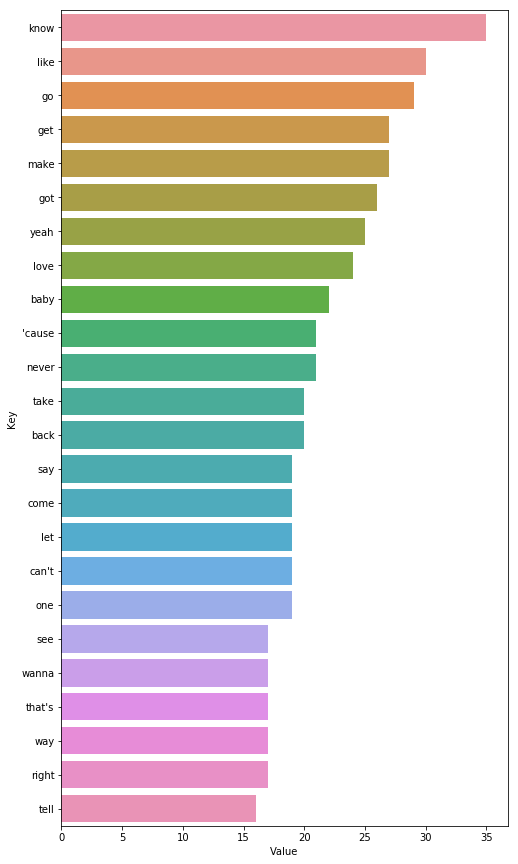

In [269]:
single_sub = {key: value for key, value in single_diction.items() if value > 15}

single_sub_diction = pd.DataFrame()
single_sub_diction["Key"] = list(single_sub.keys())
single_sub_diction["Value"] = list(single_sub.values())
single_sub_diction = single_sub_diction.sort_values("Value", ascending = False)

plt.figure(figsize=(8, 15))
sns.barplot(x = single_sub_diction["Value"], y = single_sub_diction["Key"])

We see that things are similar to a degree. However, some of the words we pointed out like "need", "want", and "wish" don't appear in at least 15 songs. However, the word "know" appears in over 30 songs! 

However, something not perfect as of now is that words such as "love" and "loving" count as separate words, even though "love" still shows up in over 20 of the 50 songs. This will be adjusted later on, but it is just a note that the results could be different depending on how many edge cases you consider, not only in this project but in general.

### VADER

Now that we have our lyrics and we did a little bit of a deep dive, we can run it in VADER's sentiment scorer. The cell below will be used to create our scorer function.

In [56]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict

In [192]:
sentiment_scores(" ".join(lyrics[13][:9]))

{'neg': 0.062, 'neu': 0.741, 'pos': 0.198, 'compound': 0.9068}

Below we have two slightly different methods of obtaining the compound sentiment scores of our songs. When we attempted to just throw in the entire song into the sentiment analyzer, it got us very extreme scores. Thus, we will take a different approach to this. 

The first method simply takes the average of each line's compound score. The second method takes each phrase/verse of the song and runs that into our sentiment analyzer, weighing the compound score according to the number of lines.

In [196]:
# method to average every line's sentiment score
cp = []
cp_pos = []
cp_neg = []
cp_neu = []
for lyric in lyrics:
    comp = 0
    pos = 0
    neg = 0
    neu = 0
    lines = 0
    words = ""

    for line in lyric:
        if "[" in line:
            continue
        if line == "":
            continue
        sent = sentiment_scores(line)
        comp += sent['compound']
        pos += sent['pos']
        neg += sent['neg']
        neu += sent['neu']
        lines += 1
    cp.append(comp / lines)
    cp_pos.append(pos / lines)
    cp_neg.append(neg / lines)
    cp_neu.append(neu / lines)

In [197]:
# method to obtain sentiment scores for each phrase/verse, and to average out 
# the weighted scores of these segments

cpounds = []
cpounds_pos = []
cpounds_neg = []
cpounds_neu = []

for lyric in lyrics:
    comp = 0
    pos = 0
    neg = 0
    neu = 0
    phrase = 0
    lines = 0
    words = ""
    for line in lyric:
        if "[" in line:
            continue
        if line == "":
            if words == "":
                continue
            sent = sentiment_scores(words)
            comp += sent["compound"] * lines
            pos += sent['pos'] * lines
            neg += sent['neg'] * lines
            neu += sent['neu'] * lines
            phrase += 1
            words = ""
            lines = 0
        else:
            lines += 1
            words += line + " "
        #sent = sentiment_scores(line)
        #print(sent)
        #comp += sent['compound']
    cpounds.append(comp / phrase)
    cpounds_pos.append(pos / phrase)
    cpounds_neg.append(neg / phrase)
    cpounds_neu.append(neu / phrase)

We will now see how these two methods compare side-by-side for each aspect of the scoring function.

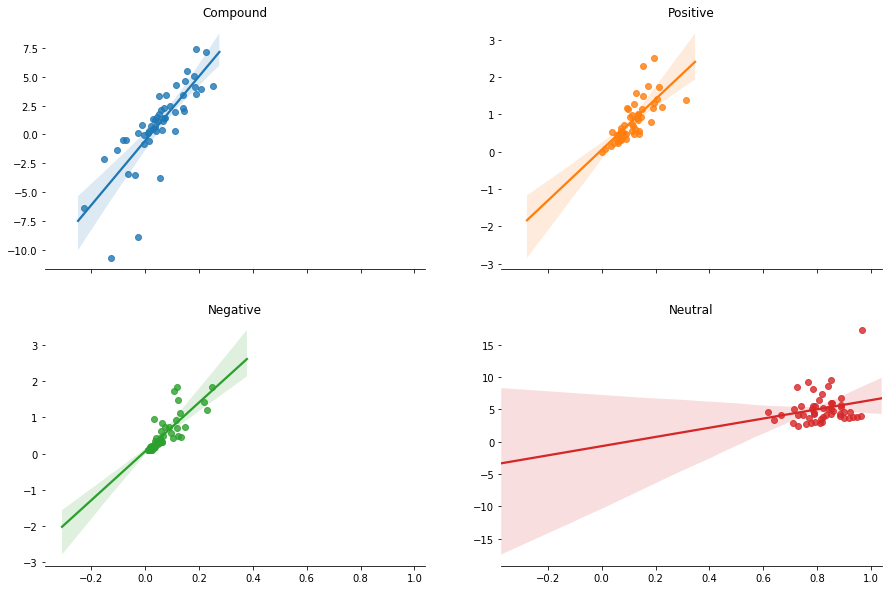

In [210]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.regplot(cp, cpounds, ax=axes[0, 0])
sns.regplot(cp_pos, cpounds_pos, ax=axes[0, 1])
sns.regplot(cp_neg, cpounds_neg, ax=axes[1, 0])
sns.regplot(cp_neu, cpounds_neu, ax=axes[1, 1])
axes[0, 0].set_title("Compound")
axes[0, 1].set_title("Positive")
axes[1, 0].set_title("Negative")
axes[1, 1].set_title("Neutral")
plt.show()

From the comparison above, it seems that the relationship is quite linear, with a few instances that show a notable difference. For simplicity of our model, we will go with the method that averages every line. These values are kept between 0 and 1.

We will now add these to our dataframe.

In [223]:
tens_df["pos_sent"] = cp_pos
tens_df["neg_sent"] = cp_neg
tens_df["neu_sent"] = cp_neu
tens_df["compound_sent"] = cp

We will attempt to visualize our features now, first comparing them with one another, and then to the audio features.

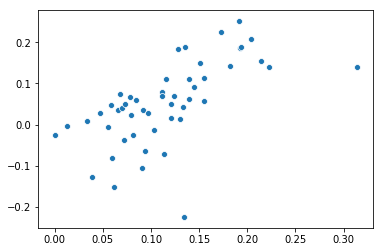

In [243]:
sns.scatterplot(cp_pos, cp)

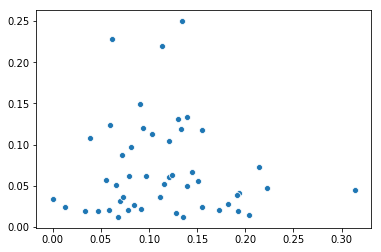

In [225]:
sns.scatterplot(cp_pos, cp_neg)

To start out, we see that compound scores are generally pretty extreme for our songs. And also, positive and negative scores on their own don't seem to show a correlation as they are right now. This can be partially because the positive and negative scores for each song may vary in how much of the sentiment they take up (in relation to neutral sentiment).

We will try to show positive and negative sentiment scores in a different light, showing them in the context of how much of the non-neutral proportion they take up.

In [232]:
weight_pos = tens_df["pos_sent"] / (tens_df["pos_sent"] + tens_df["neg_sent"])
weight_neg = tens_df["neg_sent"] / (tens_df["pos_sent"] + tens_df["neg_sent"])

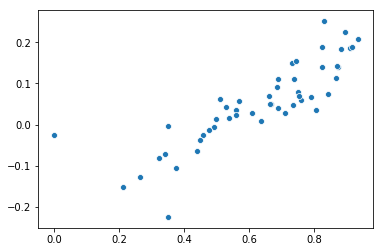

In [235]:
sns.scatterplot(weight_pos, cp)

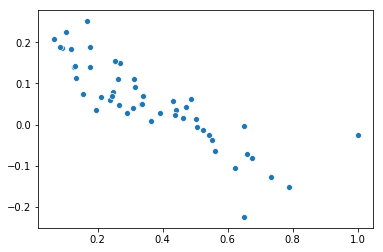

In [236]:
sns.scatterplot(weight_neg, cp)

The two mirrored graphs (we expect them to be mirrored) a linear relationship to the compound score. It is interesting to see that a majority of the songs in this playlist are in the half of the graph that corresponds to positive sentiment.

We will try another feature: taking the weighted positive score and subtracting it by the weighted negative score, to see whether a higher positive score will make a difference in relation to two of our audio features: valence and energy.

In [250]:
pos_neg = tens_df["pos_sent"] - tens_df["neg_sent"]

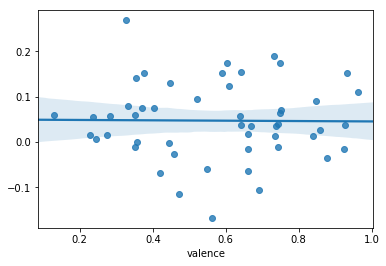

In [251]:
#sns.scatterplot(weight_pos, tens_df["valence"] * tens_df['energy'])
sns.regplot(x=tens_df["valence"], y = pos_neg)

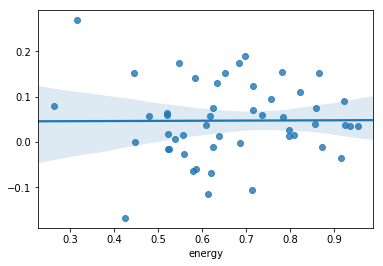

In [252]:
sns.regplot(x=tens_df['energy'], y = pos_neg)

It looks like there doesn't seem to much correlation between valence and our new feature, nor energy and our new feature.

What we will try next is to visualize the comparison between our numeric features, including our features related to sentiment. Some features, such as mode and time signature, don't provide as much potential to show us information. Thus, we will omit them.

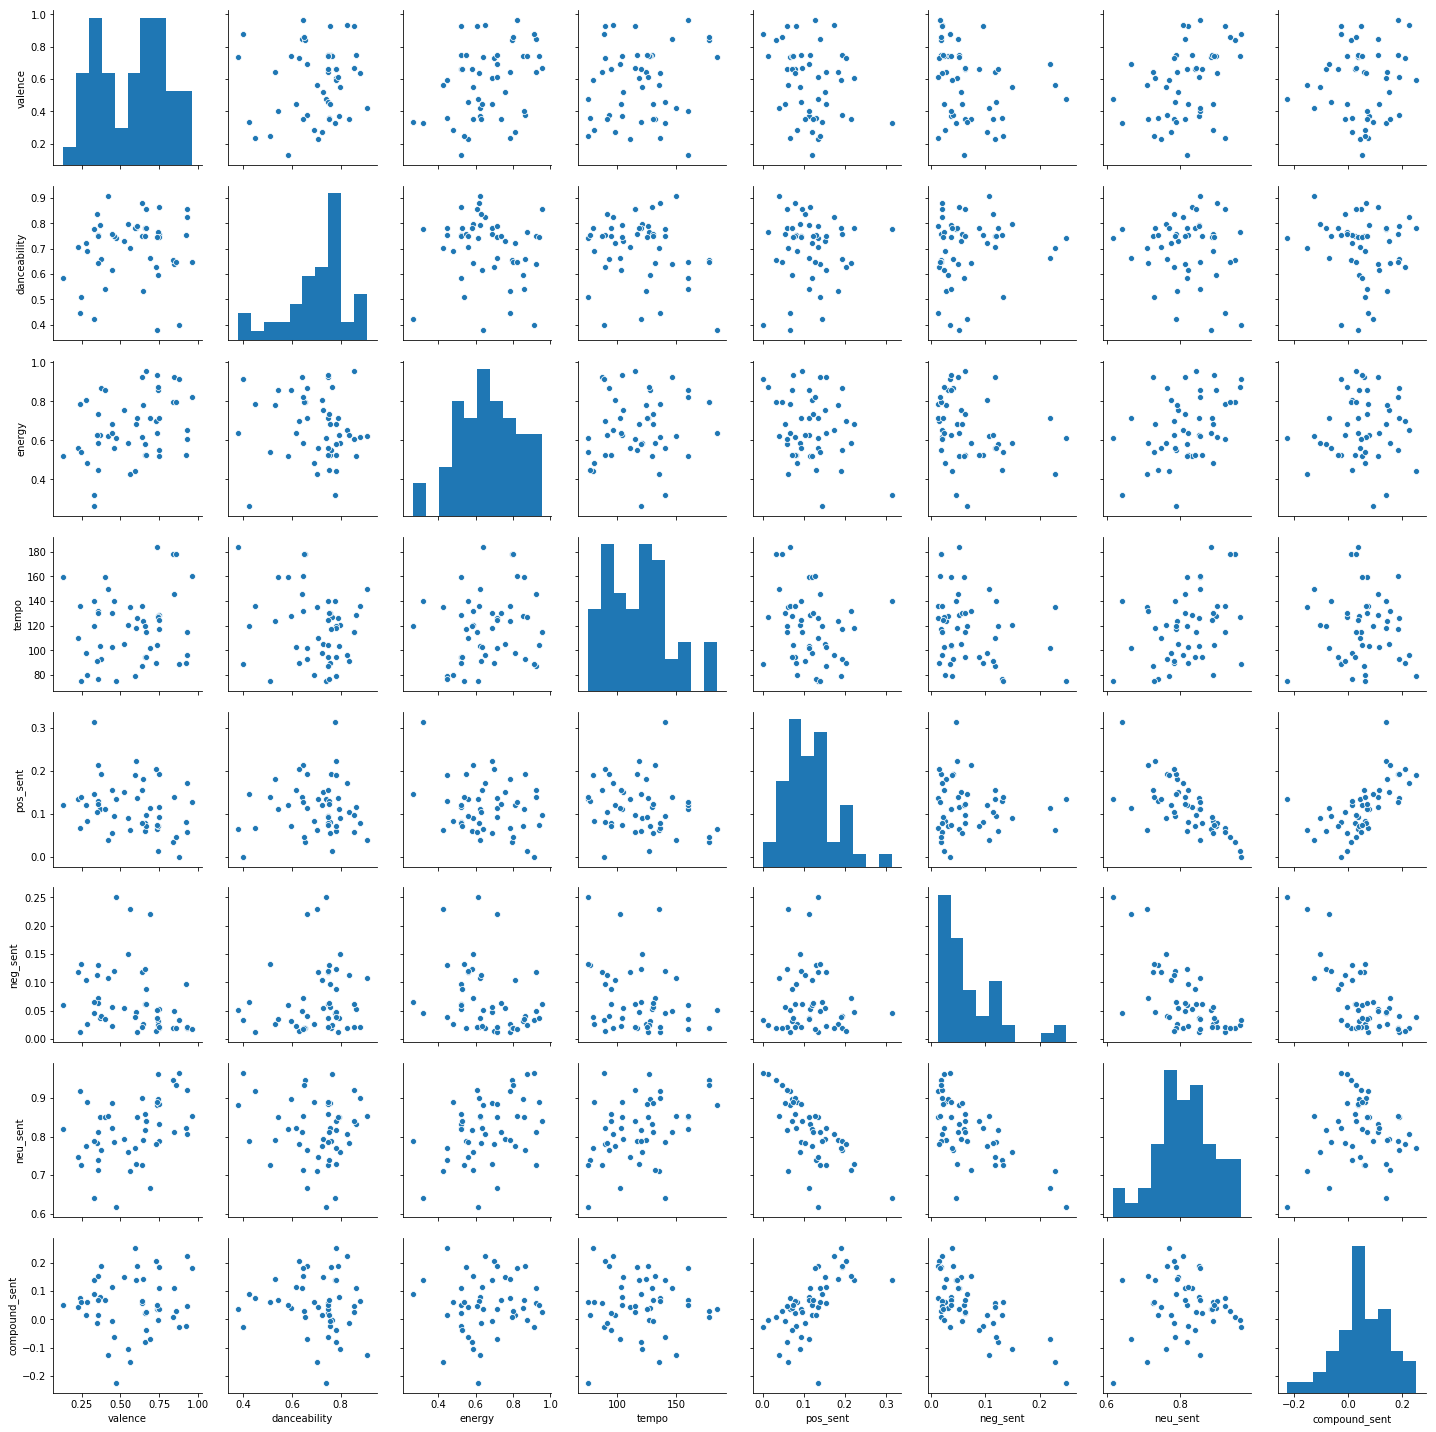

In [253]:
numers = ["valence", 'danceability', 'energy', 'tempo', 
         'pos_sent', 'neg_sent', 'neu_sent', "compound_sent"]
sns.pairplot(tens_df[numers])

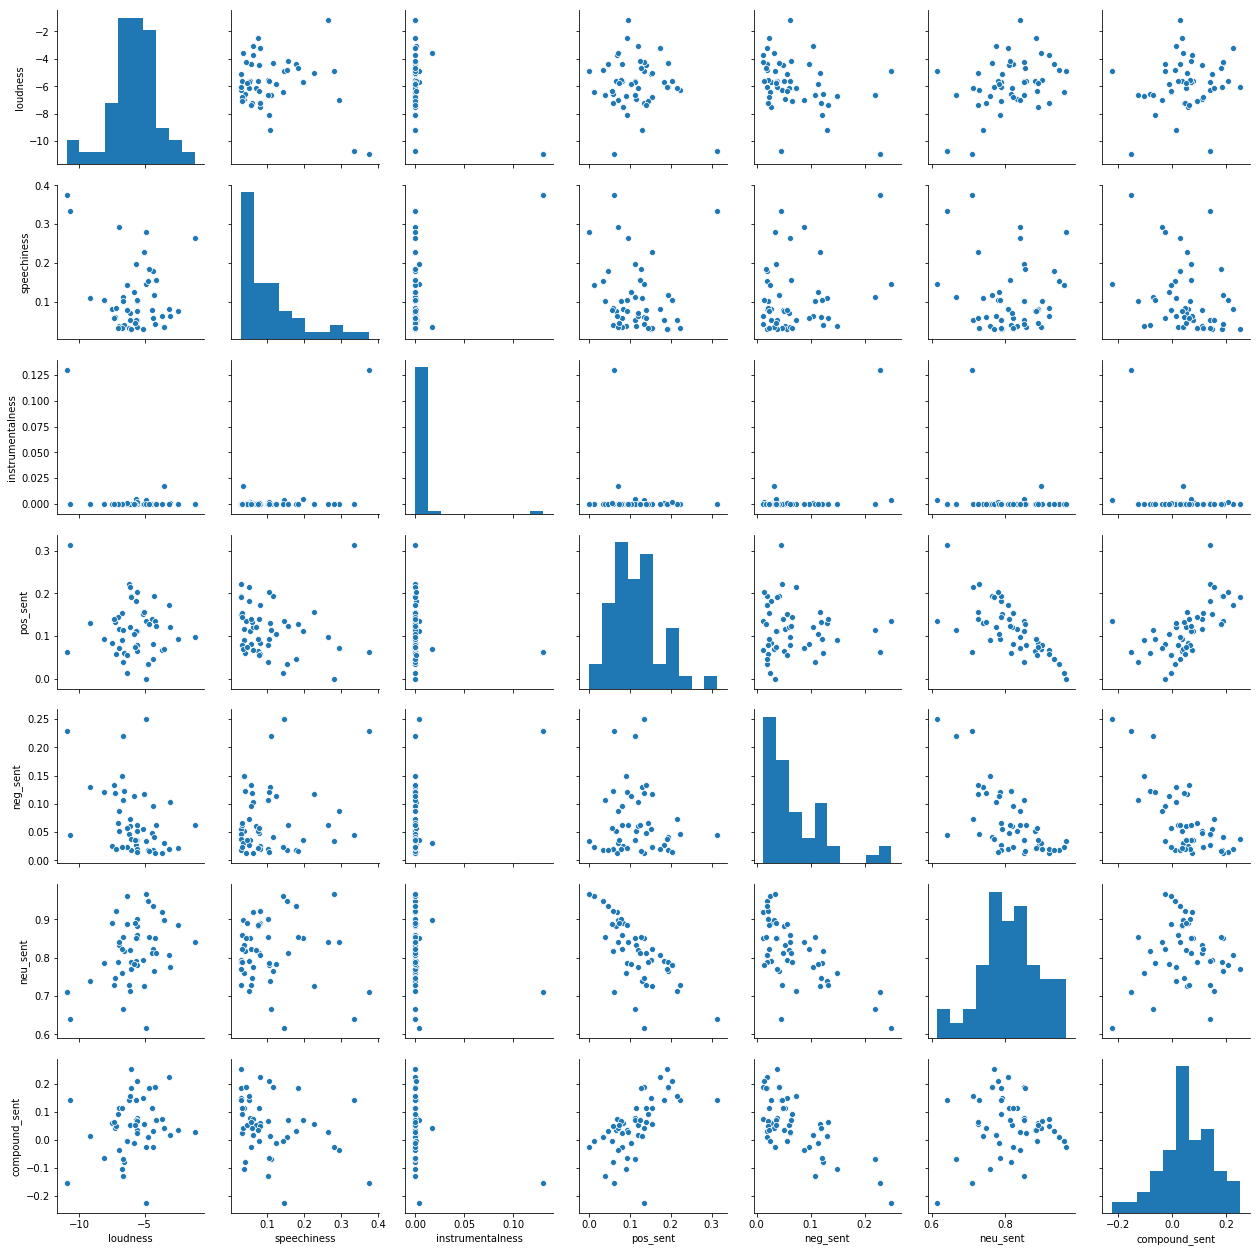

In [254]:
numers_2 = ['loudness', 'speechiness', 'instrumentalness', 
            'pos_sent', 'neg_sent', 'neu_sent', 'compound_sent']
sns.pairplot(tens_df[numers_2])

So from initial analysis, it is difficult to see significant linear correlation between the audio features and the sentiment analysis features. The most interesting thing to note is to see that there is some correlation between neutral sentiment and some of the audio features such as "energy" and "loudness". 

(Sidnote: it makes it interesting to consider what the word neutral means, whether it's just no sentiment, or sentiment that can be swayed either to the positive or negative direction depending on the listener's mood and interpretation.)

Another likely explanation has to do with our data - we chose a "hodgepodge" of songs, without any information about genre. It's very likely that the audio features show information regarding genre, which can then be used to help with our sentiment analysis of lyrics. This will be the next step of our analysis. Also, because of the way our lyrics input is, it is possible that a lack of punctuation may have contributed to the scores in place. 

## Future Ideas for Analysis

In the context of comparing sentiment of lyrics to audio features, there are other avenues that can be taken, which may appear in a future update:

* Take genres and audio features of genres and compare to lyrical sentiment - see if there is a relationship between lyrical sentiment and audio features for genres.
* A deep dive into audio features for specific genres/artists - see if a model can be trained to predict for genre of an artist based on audio features
* Build personal sentiment analyzer and compare to Vader 